# ISR Super resolution 

In [ ]:
#!pip install ISR
#!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
%%writefile new_requirements.txt
ISR
h5py==2.10.0
onnxruntime
tf2onnx

Writing new_requirements.txt


In [ ]:
!pip install -r new_requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 4.9 MB 44.1 MB/s 
     |████████████████████████████████| 442 kB 44.3 MB/s 
     |████████████████████████████████| 86.3 MB 49 kB/s 
     |████████████████████████████████| 449 kB 57.3 MB/s 
     |████████████████████████████████| 3.8 MB 42.3 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 13.1 MB 54.8 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=555c566b3b34d742881074d7606627f0f98c21dc28cf5f2933dc9807d7f10ba4
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: h5py
    Found existing inst

In [ ]:
from ISR.models import RDN

In [ ]:
rdn = RDN(weights='noise-cancel') 


In [ ]:
rdn.model.save("my_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
import os 
os.system("python -m tf2onnx.convert --saved-model my_model --output model.onnx --opset 13")

0

In [ ]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
import numpy as np
from PIL import Image

img = Image.open('/content/istockphoto-1143546879-612x612.jpg')
x = np.array(img,dtype=np.float32) 
# x = np.rollaxis(x, 2, 0)
x = np.expand_dims(x, axis=0)

In [ ]:
x.shape

(1, 3, 408, 612)

In [ ]:
x.shape

In [ ]:
sup = rdn.predict(np.array(img))


In [ ]:
Image.fromarray(sup)

In [ ]:
import numpy
import onnxruntime 

sess = onnxruntime.InferenceSession("/content/model.onnx")
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
pred_onnx = sess.run(None,  feed)[0]
pred = np.squeeze(pred_onnx)

In [ ]:
pred.shape
# pred = np.rollaxis(pred, 1, 0)

(816, 1224, 3)

In [ ]:
im_rgb = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

In [ ]:
type(pred)

numpy.ndarray

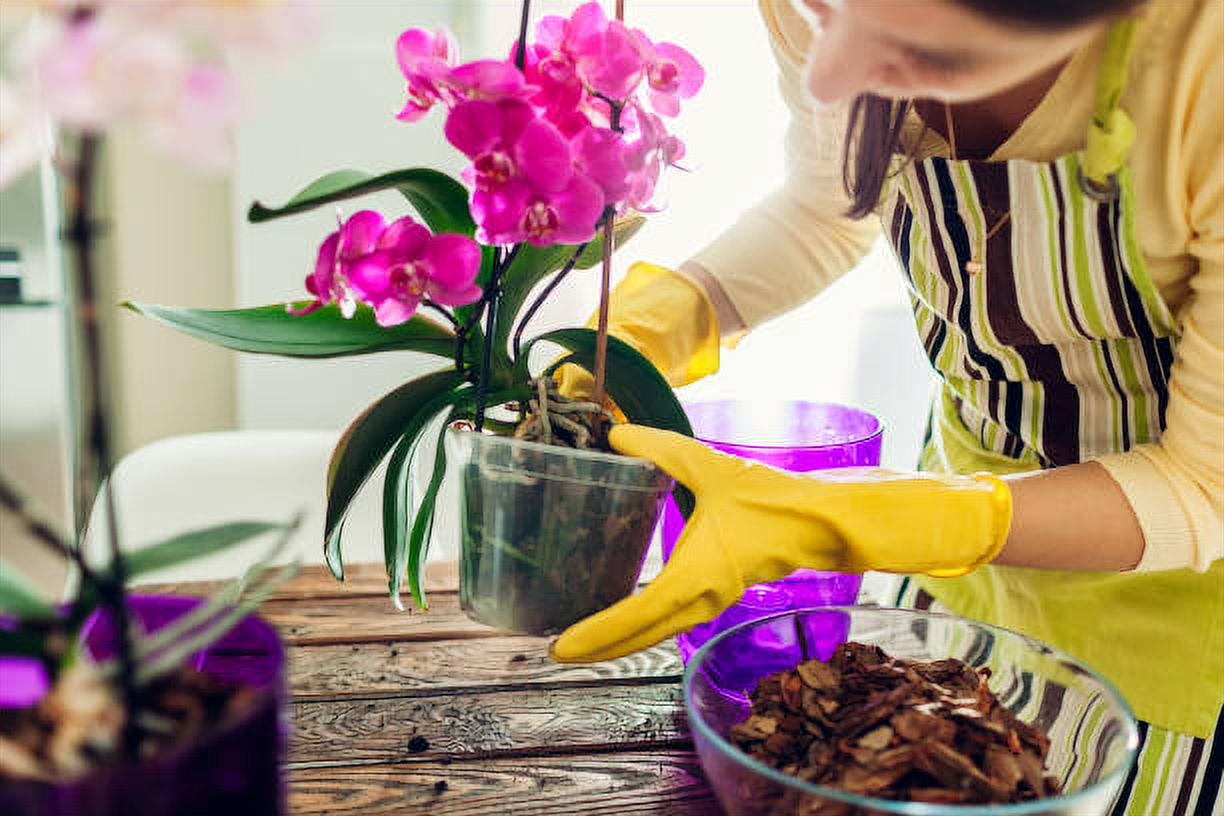

In [ ]:
cv2_imshow(im_rgb)

In [ ]:
Image.fromarray((pred * 1).astype(np.uint8)).convert('RGB')

In [ ]:
pred_img = Image.fromarray((pred * 1).astype(np.uint8)).convert('RGB')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.fastNlMeansDenoisingColored(np.array(pred_img),None,20,20,7,21))

In [ ]:
np.array(pred_img).shape

(816, 1224, 3)

In [ ]:
pret = np.array(pred_img)

In [ ]:
type(pret)

In [ ]:
!du -sh *

In [ ]:
import io
from PIL import Image

imageFileObj = open("/content/young-sensual-model-girl-outdoor-black-white-photo-35556294.jpg", "rb")
imageBinaryBytes = imageFileObj.read()
imageStream = io.BytesIO(imageBinaryBytes)
imageFile = Image.open(imageStream)
print( imageFile.size)

# FastAPI Implementation of ONNX Model


In [ ]:
!pip install colabcode
!pip install fastapi[all]
!pip install pyngrok

In [ ]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvzf ngrok-v3-stable-linux-amd64.tgz
!ngrok authtoken 29vr8YhWZ9CDHrUq2kr0CpUA0e8_6ik4hU5GjJZeAYagTH5i4

--2022-08-06 23:58:01--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7189521 (6.9M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]   6.86M  31.6MB/s    in 0.2s    

2022-08-06 23:58:01 (31.6 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [7189521/7189521]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import os
import uvicorn
from fastapi import FastAPI, File, UploadFile, Response
from fastapi.responses import StreamingResponse, FileResponse
import numpy as np
import io
from PIL import Image
import cv2
from ISR.models import RDN
import warnings
import onnxruntime 
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

app = FastAPI()



@app.get('/')
def home():
    return {'Title': 'Super Resolution and Colorisation API'}


# endpoint for just enhancing the image
@app.post("/enhance")
async def root(file: UploadFile = File(...)):
    

    contents = io.BytesIO(await file.read())
    new_img = Image.open(contents) 
    x = np.array(new_img,dtype=np.float32) 
    x = np.expand_dims(x, axis=0)
    sess = onnxruntime.InferenceSession("/content/model.onnx")
    x = x if isinstance(x, list) else [x]
    feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
    pred_onnx = sess.run(None,  feed)[0]
    pred = np.squeeze(pred_onnx)
    im_rgb = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    # pred_img = Image.fromarray((pred * 1).astype(np.uint8)).convert('RGB')
    res, im_png = cv2.imencode(".png", im_rgb)
    return StreamingResponse(io.BytesIO(im_png.tobytes()), media_type="image/png")

    #contents = io.BytesIO(await file.read())
    #file_bytes = np.asarray(bytearray(contents.read()), dtype=np.uint8)
    #img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    #sr_img = rdn.predict(img, by_patch_of_size=300)

    #res, im_png = cv2.imencode(".png", sr_img)

    



In [ ]:
from colabcode import ColabCode
cc = ColabCode(port=18000, code=False)
cc.run_app(app=app)



Public URL: NgrokTunnel: "https://88a4-35-231-8-131.ngrok.io" -> "http://localhost:18000"


INFO:     Started server process [2765]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:18000 (Press CTRL+C to quit)


INFO:     102.89.32.182:0 - "GET / HTTP/1.1" 200 OK
INFO:     102.89.32.182:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     102.89.32.182:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     102.89.32.182:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     102.89.32.182:0 - "POST /enhance HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2765]
